# <div align="center">Project 2a: Correlation Power Analysis (CPA) - Data Acquisition<div>

<p><div align="center">Due Date: Sunday April 19th, 2020, 11:59 PM</div></p>

<div align="center"><b>You are expected to work in groups of two. Address all questions listed in this document in your final report. Submit the report on <a href="https://mymasonportal.gmu.edu" target="_blank">MyMason</a> in PDF format.</div>

Correlation Power Analysis (CPA) is a variant of power side channel analysis that collects many power traces while the device under test (DUT) is performing a cryptographic operation. The attacker selects an attack piont where an intermediate value is calculated in the device. The intermeadiate value should be a function of known data (e.g plaintext) and a small portion of the key.
The attacker uses all possible values of the key portion to calculate the possible values of the intermediate. A power model (e.g. Hamming weight or distance) is used to calculated values propotional to the power consumtion of the device while it calculates the intermediate. These values are called the hypothetical power.
The real power traces collected are statistically correlated with hypothetical power to find the key portion most likley used in the crypto operation.

In this project, you will be using [FOBOS 3](https://cryptography.gmu.edu/fobos/), the soon to be released latest version of FOBOS, to perform a Correlation Power Analysis (CPA) attack on an FPGA implementation of the Advanced Encryption Standard (AES).

FOBOS stands for *Flexible Open-sources workBench fOr Side-channel analysis* and was developed by the [Cryptographic Engineering Research Group (CERG)](https://cryptography.gmu.edu) at GMU. FOBOS, loosely named after the Greek god Phobos (φóβoς) who personifies fear and can pierce shields, was designed to be an inexpensive side channel analysis setup that includes a complete software package with programs for device under test (DUT) control, data acquisition and data analysis. In order to evaluate side-channel leakage of hardware platforms, FOBOS uses off-the shelf FPGA boards as
control and victim which are less expensive than the traditional setup. FOBOS3 adds a data acquisition board designed by CERG with an Analog to Digital Converver (ADC) which enables measurements of power consumption and replaces the oscilloscope of traditional setups. Communication with the PC is now handled via Ethernet.

For this lab we provide Internet access to an SCA workstation connected to the FOBOS 3 setup in the CERG lab shown on the picture below. On the left is the *FOBOS Control* board comprised of a *Xilinx PYNQ* system on chip FPGA board and the *FOBOS Shield* data acquisition board with an ADC for power measurements. *FOBOS Control* is connected via a ribbon cable and the *FOBOS Multitarget Connector (MTC)* to the *Device under Test (DUT)* on the right of the picture. The DUT gets the core voltage for the FPGA from a *lab power supply*. The core voltage passes through a *Current Probe*, so that changes in the current consumption of the DUT can be measured by the ADC on the *FOBOS Shield*. The SCA workstation hosts this jupyter notebook and talks to *Fobos Control* via a *Network Interface*.
![FOBOS 3 Lab Setup](figures/FOBOS3-lab-setup.jpg "FOBOS 3 Lab Setup")

## Side Channel Analysis Process

### Step 1: Point of Attack and Power Model

First we need to choose a point during the run time of the crypto algorithm in which we want to attack, i.e., the *Attack Point*. We choose it to be the point in time where an intermediate result is computed as a funcion of a known data value and the key. The intermediate value is calculated as *f(d, k)* where *d* is a known non-constant value that can be derived from known data (e.g. plaintext) and *k* is small part of the key. 

AES applies four different transformations, SubBytes, ShiftRows, MixColumns, and AddRoundKey, per round and iterates through several such rounds depending upon the key size. An intermediate key called "round key" is generated and used per round which is derived from the original key through a reversible key scheduling function. We have implemented a basic iterative architecture of AES with 128-bit key length and 128-bit wide datapath requiring 11 clock cycles for one encryption. Key scheduling is done on-the-fly and the SubBytes function is realized through look-up-tables. The image below shows the block diagram of the AES-128 that we attack in this project. 

![AES Block Diagram](figures/aes128.png "AES Block Diagram")

We attack our AES design during the first round at the output of the register FF1 as indicated in the figure above. The hypothetical power $P_{est.}$ is calculated for each round key byte $j$ using the Hamming Distance (HD) equation:

$P_{est.}(i,j) = H(i,j) = HD(SBOX(CT_i), SBOX(k_{guess_j} \oplus PT_{i+1} ))$

The attack is performed on one key byte at a time.
    



### Step 2: Data Acquisition - Power Measurements

We measure the power consumption of the crypto device (DUT) while it encrypts $D$ data blocks. We need to know the value $d$ that corresponds to each data block. These values can be written as a vector $\mathbf{d} = [d_1, d_2, \ldots, d_D]$. 
A single power measurement value obtained from an oscilloscope or ADC is called a sample.
All samples collected during a single encryption or decryption operation comprise a trace.
The trace generated while encrypting or decrypting data block $d_i$ consists of $T$ samples and can be viewed as a vector $\mathbf{t}_i = [t_{i,1}, t_{i,2}, \ldots, t_{i,T}]$.
The traces are stacked in a matrix $\mathbf{T}$ with dimensions $D \times T$ where each row $i$ is a trace generated while encrypting or decrypting block $d_i$.


The setup provided to you is composed of the following components:

1. **FOBOS3 control board**: Receives test vectors from the SCA workstation and forwards them to the DUT. Once the DUT starts processing a test vector (running the crypto algorithm), the control board collects the instantaneous power consumption changes of the DUT using a current probe. The control board also generates the clock signal for the DUT and controls the trigger signal (used to trigger ADC/oscilloscope to collect a trace)

2. **DUT board**: Here we instantiate the crypto core (a.k.a victim: AES-128) which we want to attack. We need to measure the power consumption of this board. We have a Digilent Nexys 3 board (uses a Xilinx Spartan6 FPGA) as a DUT board.

3. **SCA workstation** : This is the machine where all capture/analysis scripts can be run. To collect traces, you run a script that connects to the control board via network, send test vectors one at a time, and receives results (ciphertext) and traces back from the control board. Results and traces are stored in files in the DPA workstation for furtuher analysis.

### Step 3: Data Analysis

This step will be performed in Project 2 part b).

## FOBOS Acquisition Setup
  
### Files and Locations:

FOBOS uses a WORKSPACE folder, typically called <code>fobosworkspace</code>, to store projects. 
A project is an experiment, in which a user tries to assess the vulnerability of a cipher to an SCA attack. 
Each project has a PROJECT_NAME. As we are attacking an implementation of AES, we simply name it <code>aes</code>. You can change it though to anything you like as long as its a valid Linux directory name. FOBOS expects configuration files inside the project directory.

- PLAIN_FILE <code>plaintext.txt</code> contains one plaintext block for AES per line.
- KEY_FILE <code>key.txt</code> contains the key we want to use.
- DIN_FILE_NAME <code>dinFile.txt</code> contains test vectors in FOBOS format that will be send to the DUT. These testvectors contain the plaintext as well as the key. It was created using the script blockCipherTVGen.py (not provided). This script also generated <code>plaintext.txt</code>. 
- DUT_BIT_FILE <code>half_duplex_dut.bit</code> contains the bitstream needed to program the DUT FPGA with the algorithm under test.


In order to examine the contents of a file go with the mouse to the top this notebook, click *File -> Open*. This will open a new browser tab for you. Go to *fobosworkspace/aes*. Click on the box next to the file, e.g. <code>plaintext.txt</code>, and select *View* from the menu that just opened. Using this technique you can look into files without having a jupyter notebook trying to interpret its contents. If you had just clicked on the file you would see an empty jupyter notebook. You would have to close that browser tab without saving it or <code>plaintext.txt</code> could get distroyed. 

<div class="alert alert-block alert-info">
    
#### Questions:

1. What is the value of the first block we use as input (plaintext)? 
2. How many bytes are in the block and why?
3. How many blocks does this file contain?
</div>

FOBOS creates a directory called <code>capture</code> inside the project folder. Each time you run test vectors and measure traces, a new folder <code>attempt-</code>number is created inside the <code>capture</code> directory. It will contain a copy of the <code>dinFile.txt</code> and the <code>plaintext.txt</code> files as well as the output files:

- CIPHER_FILE <code>ciphertext.txt</code> contains the ciphertext that the cipher generated from the test vectors.
- TRACE_FILE <code>powerTraces.npy</code> contains the oscilloscope measurements for all traces in numpy format.

    
Run the following cell (Shift + Enter) to import libraries needed for the capture software and configure input and output files.

In [15]:
# import libraries
import os
import sys
import shutil
import json
import fobos.pynqctrl
from fobos.fobosctrl import FOBOSCtrl
import fobos.projmgr
import fobos.nexys3dut
import numpy as np
#######################################################
# acquisition configuration
# connection to ctrl board
acqConf = {}
acqConf['ip'] = '192.168.10.99'
acqConf['port'] = 9995
# File names and locations
acqConf['workspace'] = "fobosworkspace"     # Folder to store projects
acqConf['projectName'] = "aes"              # Name of this project. Files will be in WORKSPACE/PROJECT_NAME/
acqConf['plainFile'] = "plaintext.txt"      # plaintext in hex
acqConf['dinFile'] = "dinFile.txt"          # test vectors in FOBOS format incl. plaintext and key
acqConf['bitFile'] = "half_duplex_dut.bit"  # Bitstream for programming the DUT (target) 
acqConf['cipherFile'] = "ciphertext.txt"    # observed ciphertext, result from applying test vectors
acqConf['traceFile']  = "powerTraces.npy"   # Name of file for recording power traces

### Acquisition Settings:

The next thing we have to configure are the specifics for the test. This includes the number of traces we want to run, how fast the DUT clock should run, the oscilloscope configuration, and what the output length of the cipher is.

- TRACE_NUM is the number of traces we want to run. As we are still fine tuning the other parameters, we should start with a small number, e.g. 10.
- DUT_CLK is the clock frequency of the device under test in MHz. Slow clock frequencies lead to a cleaner signal, hence we typically run at 1 MHz.
- SAMPLING_FREQ specifies how fast the oscilloscope should sample (measure) the power consumption. The unit is Msps which stands for Million samples per second.
- SAMPLES_PER_TRACE tells the oscilloscope after how many samples it should stop recording for each trace.
- ADC_GAIN specifies the how much the signal from the power probe should be amplified. The goal is to have a signal use most of the range between 0..1024 as our oscilloscope has a 10-bit ADC. If the sginal gets clipped, i.e. has straight lines on top or bottom, the gain was too high and has to be reduced. Please be careful when changing this parameter.
- OUT_LEN tells FOBOS how many byes of output to expect from each trace. Here it is the block size of AES in bytes.


<div class="alert alert-block alert-info">

#### Questions:

4. In the code below, set the DUT clock frequency DUT_CLK to 1 MHz and oscilloscope sampling frequency SAMPLING_FREQ to 50 Msps. How many samples will be collected every DUT clock cycle?
5. If you want to collect the entire AES encryption process for one test vector (one block), what is the number of samples you need to collect. (Hint : This implemetation needs first 4 clock cycles to load data + 11 clock cycles to finish the AES encryption). Using the number of samples you calculated, set the SAMPLES_PER_TRACE in the script. Leave all the other parameters at the default settings.
</div>

After you finish the configuration, run the following cell.

In [16]:
#Acquistion configuration
acqConf['traceNum'] = 10          # number of traces to run [default: 10]
acqConf['DUTClk'] = 1             # clock frequency of the DUT in MHz, [range: 1 - 100]
acqConf['samplingFreq'] = 50      # sampling frequency of the Oscilloscope in Msps [default: 50][range: 1 - 100]
acqConf['samplesPerTrace'] = 1000 # number of sample in one trace [range: 1 - 2^17]
acqConf['ADCGain'] = 50           # amplification of ADC input signal [default: 40][range: 0 - 60]
acqConf['outLen'] = 16            # number of output bytes from AES-128

## FOBOS Acquisition Measurements

### Run the Measurements

The next cell runs the measurements. First, it acquires access and then connects to the harware. This locks the hardware while you are  using it. Once you finish the hardware is released to allow others to access it.
You should see a message saying 'Acquired hardware lock'. If the hardware is used it will wait for some time until hardware is available. If this does not work, please try again after few minutes. But **please do not interrupt this cell if it is still trying to acquire access**.

Once the hardware is accessed, the script first applies the configuration parameters you configured previously to the control board and the oscilloscope / ADC. Then it programms the FPGA of the DUT. It specifies the input and output files and creates a new folder <code>attempt-</code>number inside the <code>capture</code> directory for the output files and copies the input files <code>dinFile.txt</code> and <code>plaintext.txt</code> files into it. 

<span style="color:red">Please pay attention to the messages generated by the next cell and note the attempt-xx directory number.</span>

After all this setup, it sends the test vectors one at a time to the control board, receives the ciphertext and power traces.

Once its done, it will release the hardware lock so that other students can use it. You should see a message saying 'Released hardware lock.'.

In [17]:
# connect to hardware and lock it ######################################
ctrl = fobos.pynqctrl.PYNQCtrl(acqConf['ip'], acqConf['port'])
# Apply config to ctrl board ###########################################
try:
    ctrl.setDUTClk(acqConf['DUTClk'])
    ctrl.setDUTInterface(FOBOSCtrl.INTERFACE_4BIT)
    ctrl.setOutLen(acqConf['outLen'])
    ctrl.setTriggerMode(FOBOSCtrl.TRG_FULL)
    # configure trace sampling #############################################
    ctrl.setSamplingFrequency(acqConf['samplingFreq'])
    ctrl.setADCGain(acqConf['ADCGain'])
    ctrl.setSamplesPerTrace(acqConf['samplesPerTrace'])
except Exception as e:
    print(e)
    ctrl.disconnect()
else:
    # Configure project directories#########################################
    pm = fobos.projmgr.ProjectManager()
    pm.setWorkSpaceDir(acqConf['workspace'])
    pm.setProjName(acqConf['projectName'])
    projDir = pm.getProjDir()
    # program DUT ##########################################################
    dut = fobos.nexys3dut.Nexys3DUT()
    bitFile = os.path.join(projDir, acqConf['bitFile'])
    dut.setBitFile(bitFile)
    dut.program()
    # prepare i/o files ####################################################
    tvFileName = os.path.join(projDir, acqConf['dinFile'])
    plainFileName = os.path.join(projDir, acqConf['plainFile'])
    tvFile = open(tvFileName, "r")
    captureDir = pm.getCaptureDir()
    cipherFileName = os.path.join(captureDir, acqConf['cipherFile'])
    cipherFile = open(cipherFileName, "w")
    traceFileName = os.path.join(captureDir, acqConf['traceFile'])
    traceFile = open(traceFileName, "a+b")
    shutil.copy(tvFileName, captureDir)
    shutil.copy(plainFileName, captureDir)
    # save config to a file
    configFile = open(os.path.join(captureDir, 'acquisitionConfig.json'), "w")
    configFile.write(json.dumps(acqConf, indent=4))
    #configFile.write(ctrl.config)
    #print(ctrl.config)
    configFile.close()
    # Get traces############################################################
    print('Processing test vectors ...')
    traceNum = 0
    while traceNum < acqConf['traceNum']:
        data = tvFile.readline()
        status, result, trace = ctrl.processData2(data, acqConf['outLen'])
        cipherFile.write(result + "\n")
        np.save(traceFile, trace)
        if traceNum % 100 == 0:
            sys.stdout.write('Progress:' + "{:.2f}".format(traceNum/acqConf['traceNum']*100) + '%\r')
            sys.stdout.flush()
        traceNum += 1
    print('Data acquisition complete.')
    ctrl.disconnect() # release and reset control board.
    traceFile.close()
    cipherFile.close()
    tvFile.close()

Acquired hardware lock
Programming device using the following commands:
djtgcfg init -d Nexys3
djtgcfg prog -d Nexys3 -i 0 -f fobosworkspace/aes/half_duplex_dut.bit
DUT board programmed successfuly.
Successfully created new capture directory at fobosworkspace/aes/capture/attempt-33
Processing test vectors ...
Data acquisition complete.
Released hardware lock.


### Plot and Evaluate the Measurements
The next code cell will create a graph of the measured power consumption and plot up to 100 traces on top of each other. You can adjust the size of the plot by changing the entry for <code>figsize</code>.

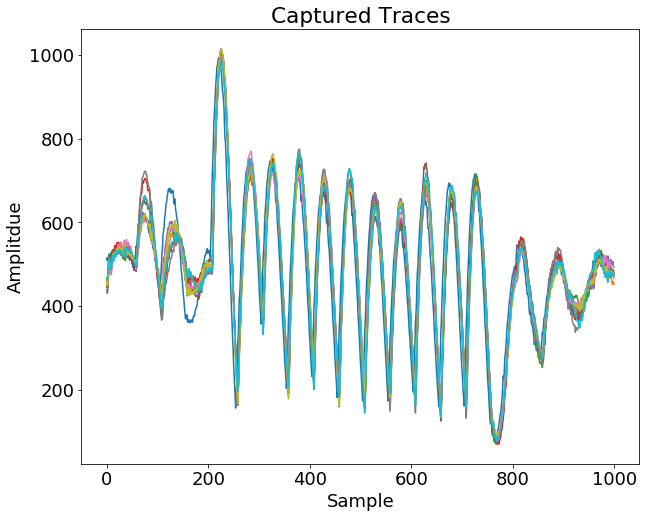

In [21]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
traceFile = open(traceFileName, "r+b")
maxtrace = 100
plt.figure(figsize=(10,8))
plt.xlabel('Sample')
plt.ylabel('Amplitdue')
plt.title('Captured Traces')
for i in range(min(maxtrace, acqConf['traceNum'])):
    trace = np.load(traceFile)
    plt.plot(trace)

plt.savefig(os.path.join(captureDir, 'traces.png'))
# plt.close()
traceFile.close()

Now lets examine the graph.

<div class="alert alert-block alert-info">

#### Questions:
    
6.  How many peaks are in the trace? The first peaks are related to loading the data, which are followed by the 
    AES-128 rounds, and, if you capture enough samples, some samples for storing the data. 
7.  How many peaks are you expecting for AES-128?
8.  Adjust the number of SAMPLES_PER_TRACE and re-run the boxes above starting from <code>#Acquisition 
    Settings</code> until you see the wave form for the complete AES. You can also carefully adjust the 
    ADC_GAIN until the wave form fills the graph without clipping. Write the settings you used
    into your report.
9.  Copy the generated graph into your report and mark the peaks relating to AES indicating the round 
    numbers.
10. Explain why the traces are not plotted precisely on top of each other but they show some variability
    (Give at least two reasons). 
11. Which range of samples corresponds to the point of attack of our power model?
12. The power trace covers the full run of AES and more. However, our power model is particular to
    the first round of the encryption. Hence, we can limit how much data we have to analyze. 
    Change the number of sampel such that the acquisition ends after the second round. This will limit 
    the amount of data you'll have to analyze. Adjust the number of SAMPLES_PER_TRACE and re-run the boxes 
    above starting from <code>#Acquisition Settings</code>. Write the settings you used
    into your report. 
13. Copy the generated graph into your report.
14. In order to run a successful attack we need many more traces than 10. Set the TRACE_NUM to 10000 and
    re-run the boxes above starting from <code>#Acquisition Settings</code>.
    Look in the fobosworkspace/aes/capture/attempt-xx directory and open ciphertext.txt using the method
    for opening files described above. How many bytes are in each ciphertext block and how many ciphertext
    blocks were captured?
</div>





By the end of this notebook you have the traces stored in the T matrix. We need this in the next step to recover the secret key used in the AES cipher!
